 # Import Libraries

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=cb07fa8ac69835f4fc3f7ffa3e8525f15ea47c34461b53a31ba30ac29dc159ea
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


# Pre-Processing

In [5]:
def get_image_path(root, folder="Train", type="Degraded_image" ): #returns paths of all the images of folder structutre
 root=root+"/drive/MyDrive"
 dataset_path=os.path.join(root, "Denoising_Dataset_train_val")
 print('Objects in the folder are-',os.listdir(dataset_path)) # Objects
 image_paths=[]
# object directories -> Train -> Degraded_image -> Miscellionus Classifications -> images
 for object in sorted(os.listdir(dataset_path)):
    object_directory_path=os.path.join(root, "Denoising_Dataset_train_val", object)
    # print(os.listdir(object_directory_path))
    for train_folder in sorted(os.listdir(object_directory_path)):
      if(train_folder==folder): #check train or val or test
        train_directory_path=os.path.join(root, "Denoising_Dataset_train_val", object, train_folder)
        # print(os.listdir(train_directory_path))
#degraded_image_folder might be mask, GT, Noise can mentioned in type
        for degraded_image_folder in os.listdir(train_directory_path):
            if(degraded_image_folder==type):
                image_folder_path=os.listdir(os.path.join(root, "Denoising_Dataset_train_val", object, train_folder, degraded_image_folder))
                # print(image_folder_path)
                for image_folder in sorted(image_folder_path):   #Miscellionus Classifications
                    image_path=os.listdir(os.path.join(root, "Denoising_Dataset_train_val", object, train_folder, degraded_image_folder, image_folder))
                    for image in sorted(image_path):
                        image_paths.append(os.path.join(root, "Denoising_Dataset_train_val", object, train_folder, degraded_image_folder, image_folder, image))
 return image_paths

In [6]:
clean_train_image_paths=get_image_path(os.getcwd(), "Train", type="GT_clean_image")
degraded_train_image_paths=get_image_path(os.getcwd(), "Train", type="Degraded_image")
#clean_train_image_paths[45],degraded_train_image_paths
len(degraded_train_image_paths), len(clean_train_image_paths)

Objects in the folder are- ['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']
Objects in the folder are- ['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']


(933, 932)

In [ ]:
#function that can load a given image as a np array
degraded_test_image=np.array(Image.open(degraded_train_image_paths[45]))
clean_test_image=np.array(Image.open(clean_train_image_paths[45]))

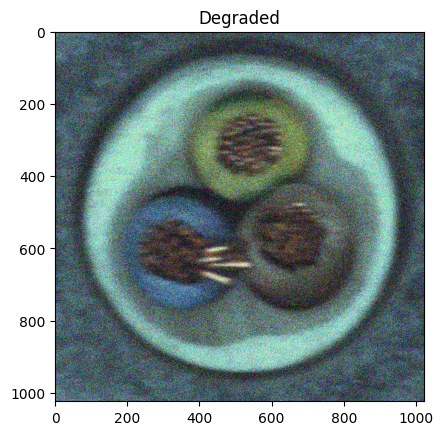

In [ ]:
plt.imshow(degraded_test_image)
plt.title("Degraded")
plt.show()

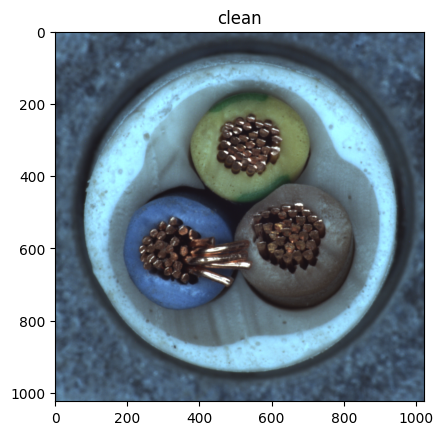

In [ ]:
plt.imshow(clean_test_image)
plt.title("clean")
plt.show()

 For the clean images, we have 932, while degraded images are 933, Delete that image from both the lists

Check the names of images in degraded list and clean list and get the one that does not match, get its index

In [ ]:
def get_image_file_names(image_list):
    image_names=[]
    for image_path in image_list:
        image_names.append(image_path[-7:])
    return image_names

In [ ]:
degraded_train_image_names =  get_image_file_names(degraded_train_image_paths)
clean_train_image_names =   get_image_file_names(clean_train_image_paths)
len(clean_train_image_names),len(degraded_train_image_names)

(932, 933)

In [ ]:
#Index of the image that is missing from clean_train_images
for i in range(len(degraded_train_image_names)):
    if clean_train_image_names[i] != degraded_train_image_names[i]:
        print(i)
        break

91


In [ ]:
clean_train_image_names[91], degraded_train_image_names[91] #Clean image is missing: 001.png, Remove image at index 91 from degraded_train_image_names

('002.png', '001.png')

In [ ]:
clean_train_image_names[90], degraded_train_image_names[90]

('000.png', '000.png')

In [ ]:
#Image.open(degraded_train_image_paths[92])

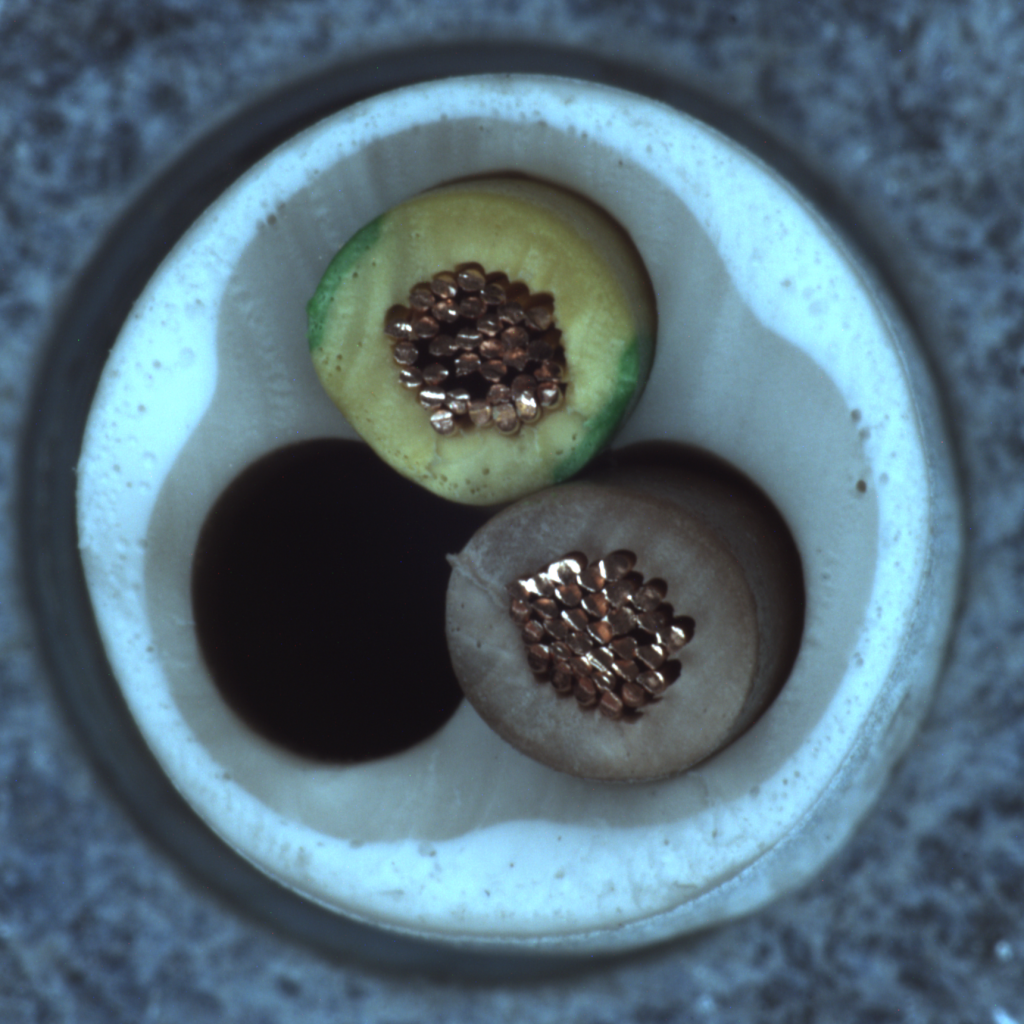

In [ ]:
#Image.open(clean_train_image_paths[91]) #clean image for index 92 of degraded_image

In [ ]:
value_to_remove=degraded_train_image_paths[91]
degraded_train_image_paths.remove(value_to_remove)
len(degraded_train_image_paths), len(clean_train_image_paths)

(932, 932)

In [ ]:
#Image.open(degraded_train_image_paths[91])

## Load these images into a Dataloader object

In [ ]:
# Few images are 900 x 900 while some are 1024 x1024 size. Make it uniform by padding
def get_images_dimensions(image_paths):

    images=[]
    different_widths=[]
    different_heights=[]
    max_height=0
    max_width=0

    for path in image_paths:
        arr=np.array(Image.open(path))
        height=arr.shape[0]
        width=arr.shape[1]
        if height not in different_heights:
            different_heights.append(height)
        if width not in different_widths:
            different_widths.append(width)
        max_height = height if height>max_height else max_height
        max_width= width if width>max_width else max_width

    print("different widhts", different_widths)
    print("Different heights", different_heights)
    print("Max height of an image is ", max_height, "max width of an image is ", max_width)

DnCNN Model

In [11]:
import torch.nn.init as init

class DnCNN(nn.Module):
    def __init__(self, depth=15, n_channels=64, image_channels=1, use_bnorm=True, kernel_size=3):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        layers = []
        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=True))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(depth-2):
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(n_channels, eps=0.0001, momentum = 0.95))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
        self._initialize_weights()

    def forward(self, x):
        y = x
        out = self.dncnn(x)
        denoised_output = y - out
        return torch.clamp(denoised_output, 0, 1)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)

In [12]:
model=DnCNN(depth=14, n_channels=64,image_channels=3).to(device)
loss_fn=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.0001)

##Dataset and DataLoader Objects

In [13]:
def convert_gray_to_rgb(image):
    if isinstance(image, np.ndarray):   # Check if input is a numpy array
        if image.ndim == 3 and image.shape[-1] == 3:   # If already RGB (3 channels), return as is
          return image
        return np.stack([image] * 3, axis=-1)  # Otherwise, convert grayscale to RGB
    if image.mode == 'RGB':   # For PIL Images, check if RGB
         return image
    return Image.merge('RGB', [image] * 3)      # Convert grayscale to RGB

def resize(image):
    if isinstance(image, np.ndarray):
         return Image.fromarray(image).resize((512, 512), Image.Resampling.BILINEAR) # adjust 256 x256 if necessary
    return image.resize((512, 512), Image.Resampling.BILINEAR)

transform = transforms.Compose([
    transforms.Lambda(convert_gray_to_rgb),
    transforms.Lambda(resize),
    transforms.ToTensor()   ])


class path_to_image(Dataset):

    def __init__(self, noisy_paths, clean_paths, transform=transform):
        self.noisy_paths = noisy_paths
        self.clean_paths = clean_paths
        self.transform = transform

    def __len__(self):
        return len(self.noisy_paths)

    def __getitem__(self, idx):
        noisy_image = Image.open(self.noisy_paths[idx])
        clean_image = Image.open(self.clean_paths[idx])
        noisy_tensor = self.transform(noisy_image)
        clean_tensor = self.transform(clean_image)
        return noisy_tensor, clean_tensor

# Create the dataset and dataloader
original_train_dataset = path_to_image(degraded_train_image_paths, clean_train_image_paths)
train_dataloader = DataLoader(original_train_dataset, batch_size=8, shuffle=True, num_workers=2)
len(train_dataloader)

117

### Training the DnCNN

In [ ]:
best_loss = float('inf')
epochs = 100
model.train()
for epoch in range(epochs):
    loss_per_batch = 0
    torch.cuda.empty_cache()
    print("Epoch", epoch + 1)
    for i, images in enumerate(train_dataloader):
        noisy = images[0].to(device)
        clean = images[1].to(device)
        # Forward pass
        reconstructed = model(noisy)
        loss = loss_fn(reconstructed, clean)
        loss_per_batch += loss.item()  # Accumulate batch loss
        # Zero the gradients
        optimizer.zero_grad()
        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

    # Calculate average loss for the epoch
    print(f"loss per batch for epoch {epoch} is {loss_per_batch}")
    avg_loss_per_epoch = loss_per_batch / len(train_dataloader)
    print(f"Average loss for epoch {epoch + 1}: {avg_loss_per_epoch}")

    # Save model if it's the best so far
    if avg_loss_per_epoch < best_loss:
        best_loss = avg_loss_per_epoch
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Best model saved at epoch {epoch + 1} with loss {best_loss}")

    # Save model at every 20th epoch
    if (epoch + 1) % 20 == 0:
        torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pth")
        print(f"Model saved at epoch {epoch + 1}")


Epoch 1
loss per batch for epoch 0 is 2.761276896111667
Average loss for epoch 1: 0.02360065723172365
Best model saved at epoch 1 with loss 0.02360065723172365
Epoch 2
loss per batch for epoch 1 is 1.1098031215369701
Average loss for epoch 2: 0.009485496765273249
Best model saved at epoch 2 with loss 0.009485496765273249
Epoch 3
loss per batch for epoch 2 is 1.0280747064389288
Average loss for epoch 3: 0.008786963302896827
Best model saved at epoch 3 with loss 0.008786963302896827
Epoch 4
loss per batch for epoch 3 is 0.9949366804212332
Average loss for epoch 4: 0.00850373231129259
Best model saved at epoch 4 with loss 0.00850373231129259
Epoch 5
loss per batch for epoch 4 is 0.9017022806219757
Average loss for epoch 5: 0.007706857099333125
Best model saved at epoch 5 with loss 0.007706857099333125
Epoch 6
loss per batch for epoch 5 is 0.8302970207296312
Average loss for epoch 6: 0.007096555732731891
Best model saved at epoch 6 with loss 0.007096555732731891
Epoch 7


KeyboardInterrupt: 

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# try if gpu overloading

In [ ]:
model.load_state_dict(torch.load("best_model_1.pth"))

<ipython-input-33-48056e11e38f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_1.pth"))


<All keys matched successfully>

# Evaluation Phase

In [ ]:
#sample_image=Image.open(degraded_train_image_paths[50])
#print(sample_image.size)
#sample_image=resize(sample_image)
#print(sample_image.size)

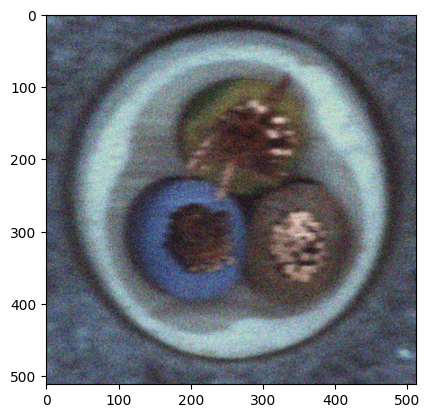

In [ ]:
#plt.imshow(test_image)

In [ ]:
#sample_image=np.array(sample_image)

In [ ]:
model.load_state_dict(torch.load("best_model_3.pth"))
model.eval()
with torch.inference_mode():
  for noisy, clean in train_dataloader:
      #print(noisy.shape)
      a=noisy[4].unsqueeze(dim=0).to(device)
      b=clean[4].unsqueeze(dim=0).to(device)
      out=model(a)
      break


<ipython-input-38-e5c04e528466>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_3.pth"))


Clean image


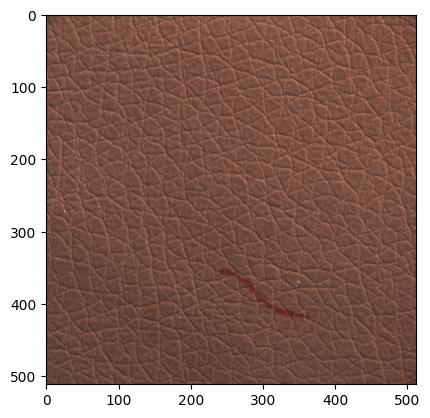

In [ ]:
print("Clean image")
plt.imshow(b[0].cpu().numpy().transpose(1,2,0))

Dataset noisy image


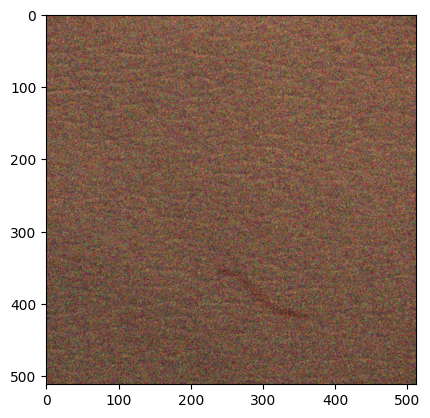

In [ ]:
print("Dataset noisy image")
plt.imshow(a[0].cpu().numpy().transpose(1,2,0))

AE Denoised image


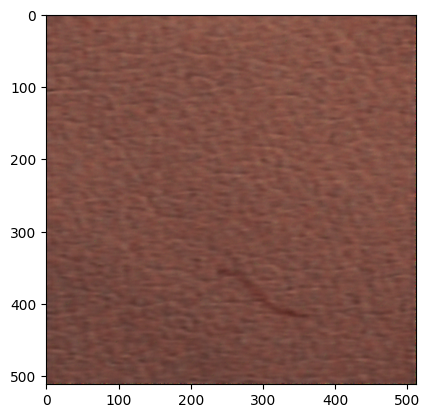

In [ ]:
print("AE Denoised image")
out=torch.squeeze(out, dim=0).cpu().numpy()
plt.imshow(out.transpose(1, 2, 0))

#PSNR for Validation data as well as for individual objects

In [8]:
import torch.nn.functional as F
def psnr(img1, img2, max_pixel_value=1.0): #this will give us the psnr value per image for a given batch, we'll have to eventually divide the outcome by total no. of batches
    mse = F.mse_loss(img1, img2)
    psnr_value = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))
    return psnr_value

In [9]:
#Load the Validation Images
degraded_val_image_paths=get_image_path(root= os.getcwd(), folder="Val", type="Degraded_image")
clean_val_image_paths=get_image_path(root=os.getcwd() , folder="Val", type="GT_clean_image")

Objects in the folder are- ['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']
Objects in the folder are- ['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']


In [ ]:
len(degraded_val_image_paths), len(clean_val_image_paths)

(88, 88)

In [14]:
val_dataset = path_to_image(degraded_val_image_paths, clean_val_image_paths)
val_dataloader = DataLoader(val_dataset, batch_size=len(degraded_val_image_paths), shuffle=False, num_workers=0) #taking batch size of one so that we can simply divide the final score by 88

In [ ]:
len(val_dataloader.dataset)

88

# PSNR For the Validation Set

In [7]:
from skimage.metrics import structural_similarity as ssim
def calculate_ssim(output, target):
    # Convert tensors to numpy arrays for SSIM calculation
    output_np = output.cpu().detach().numpy()
    target_np = target.cpu().detach().numpy()
    ssim_value = ssim(target_np, output_np, win_size=3 ,multichannel=True, data_range=output_np.max() - output_np.min())
    return ssim_value

In [15]:
#now let us test our model
model.load_state_dict(torch.load("best_model_3.pth"))
torch.cuda.empty_cache()
#device='cpu'
model.to(device)
with torch.inference_mode():
    total_loss = 0
    for noisy, clean in val_dataloader:
        noisy, clean = noisy.to(device), clean.to(device)
        reconstructed = model(noisy)
        # PSNR calculation for images in range [0,1]
        loss = psnr(reconstructed, clean, 1.0)  # Note max_pixel=1.0
        loss_2=calculate_ssim(reconstructed, clean)
        print(loss)
        print(loss_2)
        total_loss += loss
        #print(loss)
print(f"Average PSNR for the entire validation set: {total_loss:.2f} dB")
print(f"Average SSIM for the entire validation set: {loss_2:.2f} dB")

<ipython-input-15-f334ee845f68>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_3.pth"))


tensor(26.2225, device='cuda:0')
0.8141258423617312
Average PSNR for the entire validation set: 26.22 dB


PSNR/SSIM values (object-wise and overall) on the validation set:

Plot a bar chart showing PSNR/SSIM values for each object. Arrange the objects on the X-axis in alphabetical order of their names (bottle first, cable second, …).


In [17]:
def get_object_names(root): #returns paths of all the images of a given object

 root=root+"/drive/MyDrive"
 dataset_path=os.path.join(root, "Denoising_Dataset_train_val")
 object_names=[]
 for object in sorted(os.listdir(dataset_path)):
  object_names.append(object)
 return object_names

objects=get_object_names(os.getcwd())
objects

['bottle',
 'cable',
 'capsule',
 'carpet',
 'grid',
 'hazelnut',
 'leather',
 'metal_nut',
 'pill',
 'screw',
 'tile',
 'toothbrush',
 'transistor',
 'wood',
 'zipper']

In [18]:
def get_paths_of_an_object(root, object_name, folder="Val", type="Degraded_image" ): #returns paths of all the images of a given object

 root=root+"/drive/MyDrive"
 dataset_path=os.path.join(root, "Denoising_Dataset_train_val")
 image_paths=[]

 for object in sorted(os.listdir(dataset_path)):
  if object==object_name:
    object_directory_path=os.path.join(root, "Denoising_Dataset_train_val", object)
    # print(os.listdir(object_directory_path))
    for train_folder in sorted(os.listdir(object_directory_path)):
      if(train_folder==folder): #validation folder
        train_directory_path=os.path.join(root, "Denoising_Dataset_train_val", object, train_folder)
        # print(os.listdir(train_directory_path))
        for degraded_image_folder in os.listdir(train_directory_path):
            if(degraded_image_folder==type):
                image_folder_path=os.listdir(os.path.join(root, "Denoising_Dataset_train_val", object, train_folder, degraded_image_folder))
                # print(image_folder_path)
                for image_folder in sorted(image_folder_path):
                    #inside each image folder, get the images and store them in images list
                    # print(image_folder_path)
                    image_path=os.listdir(os.path.join(root, "Denoising_Dataset_train_val", object, train_folder, degraded_image_folder, image_folder))
                    # print(image_path)
                    for image in sorted(image_path):
                        #now we need to store these images in a list so that they can be accessed later
                        image_paths.append(os.path.join(root, "Denoising_Dataset_train_val", object, train_folder, degraded_image_folder, image_folder, image))

 return image_paths

In [21]:
model.eval()
psnr_scores=[]
ssim_scores=[]
with torch.inference_mode():
    for object in objects:
        degraded_object_image_paths=get_paths_of_an_object(os.getcwd(), object, "Val", "Degraded_image")
        clean_object_image_paths=get_paths_of_an_object(os.getcwd(), object, "Val", "GT_clean_image")

        degraded_images=torch.zeros(len(degraded_object_image_paths), 3, 512, 512)
        clean_images=torch.zeros(len(clean_object_image_paths), 3, 512, 512)

        for i, noisy_image in enumerate(degraded_object_image_paths):
            pil_image=Image.open(noisy_image)
            noisy=transform(pil_image)
            degraded_images[i]=noisy

        #same for clean_images    # print("clean images length is ", len(clean_images))

        for i, image in enumerate(clean_object_image_paths):
            pil_image=Image.open(image)
            image=transform(pil_image)
            clean_images[i]=image

        reconstructed_images=model(degraded_images.to(device))
        psnr_score=psnr(reconstructed_images, clean_images.to(device)).item()
        psnr_scores.append(psnr_score)
        ssim_score=calculate_ssim(reconstructed_images, clean_images.to(device)).item()
        ssim_scores.append(ssim_score)
        #print(f"SSIM for {object} is ", ssim_scores)
        print(f"psnr for {object} is ", psnr_score)
    average_psnr = sum(psnr_scores) / len(psnr_scores) if psnr_scores else 0
    average_ssim = sum(ssim_scores) / len(ssim_scores) if ssim_scores else 0
    print("Average SSIM across all categories:", average_ssim)


psnr for bottle is  26.731958389282227
psnr for cable is  25.60096549987793
psnr for capsule is  27.70871925354004
psnr for carpet is  20.63148307800293
psnr for grid is  24.275985717773438
psnr for hazelnut is  30.310144424438477
psnr for leather is  27.201934814453125
psnr for metal_nut is  27.034360885620117
psnr for pill is  29.53520965576172
psnr for screw is  26.993492126464844
psnr for tile is  24.234760284423828
psnr for toothbrush is  29.037992477416992
psnr for transistor is  28.25482177734375
psnr for wood is  26.24666976928711
psnr for zipper is  28.36189079284668
Average SSIM across all categories: 0.7623897366734652


In [ ]:
'''
output_dir = "output_images"  # Root directory for saved images
os.makedirs(output_dir, exist_ok=True)

model.eval()
psnr_scores = []

with torch.inference_mode():
    for object in objects:
        # Create directory structure for each object
        object_dir = os.path.join(output_dir, object)
        clean_dir = os.path.join(object_dir, "GT_clean_image")
        noisy_dir = os.path.join(object_dir, "Degraded_image")
        denoised_dir = os.path.join(object_dir, "Denoised_image")
        os.makedirs(clean_dir, exist_ok=True)
        os.makedirs(noisy_dir, exist_ok=True)
        os.makedirs(denoised_dir, exist_ok=True)

        # Get image paths
        degraded_object_image_paths = get_paths_of_an_object(os.getcwd(), object, "Val", "Degraded_image")
        clean_object_image_paths = get_paths_of_an_object(os.getcwd(), object, "Val", "GT_clean_image")

        # Initialize tensors for storing images
        degraded_images = torch.zeros(len(degraded_object_image_paths), 3, 512, 512)
        clean_images = torch.zeros(len(clean_object_image_paths), 3, 512, 512)

        # Process noisy images
        for i, noisy_image_path in enumerate(degraded_object_image_paths):
            pil_image = Image.open(noisy_image_path)
            noisy = transform(pil_image)
            degraded_images[i] = noisy

            # Save noisy image
            noisy_image_save_path = os.path.join(noisy_dir, f"noisy_image_{i}.png")
            pil_image.save(noisy_image_save_path)

        # Process clean images
        for i, clean_image_path in enumerate(clean_object_image_paths):
            pil_image = Image.open(clean_image_path)
            clean = transform(pil_image)
            clean_images[i] = clean

            # Save clean image
            clean_image_save_path = os.path.join(clean_dir, f"clean_image_{i}.png")
            pil_image.save(clean_image_save_path)

        # Generate and save denoised images
        reconstructed_images = model(degraded_images.to(device))
        reconstructed_images = reconstructed_images.cpu()  # Move to CPU for saving

        for i in range(reconstructed_images.size(0)):
            # Convert tensor to PIL image format
            denoised_image = reconstructed_images[i].permute(1, 2, 0).numpy()
            denoised_image = (denoised_image * 255).astype('uint8')  # Scale to 0-255 range
            denoised_image = Image.fromarray(denoised_image)

            # Save denoised image
            denoised_image_save_path = os.path.join(denoised_dir, f"denoised_image_{i}.png")
            denoised_image.save(denoised_image_save_path)

        # Calculate PSNR and store the score
        psnr_score = psnr(reconstructed_images.cpu(), clean_images.cpu()).item()
        psnr_scores.append(psnr_score)
        print(f"PSNR for {object} is {psnr_score}")

# Calculate and print average PSNR
average_psnr = sum(psnr_scores) / len(psnr_scores) if psnr_scores else 0
print("Average PSNR across all categories:", average_psnr) '''


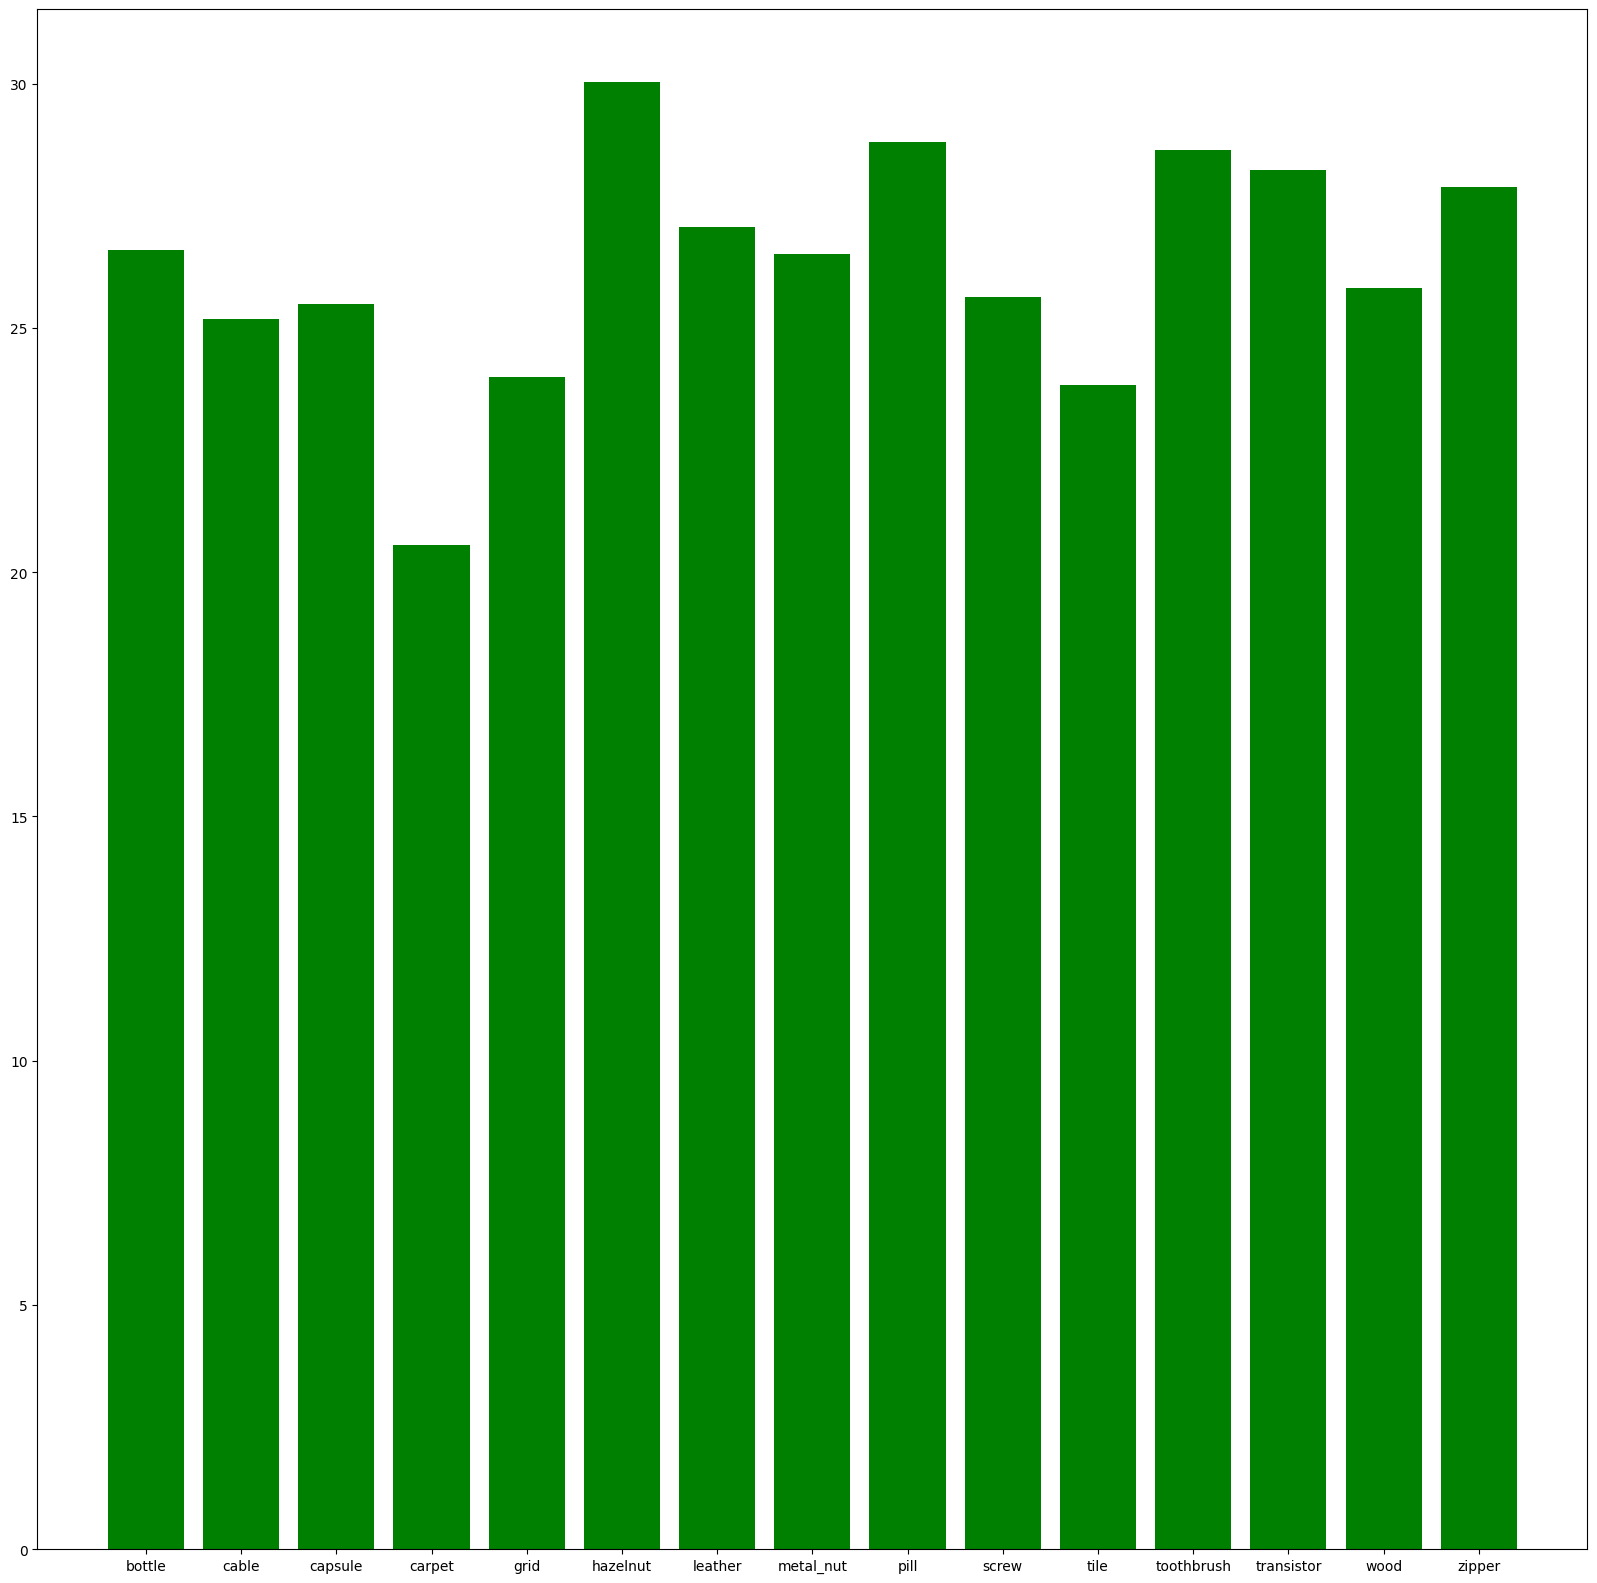

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
plt.bar(objects, psnr_scores, color='green')
plt.show()

In [26]:
'''
import os
from PIL import Image
import torch
import numpy as np

output_dir = "output_images"  # Root directory for saved images
os.makedirs(output_dir, exist_ok=True)

model.eval()
psnr_scores = []
cropped_psnr_scores = {}

with torch.inference_mode():
    for object in objects:
        # Create directory structure for each object
        object_dir = os.path.join(output_dir, object)
        clean_dir = os.path.join(object_dir, "GT_clean_image")
        noisy_dir = os.path.join(object_dir, "Degraded_image")
        denoised_dir = os.path.join(object_dir, "Denoised_image")
        cropped_denoised_dir = os.path.join(object_dir, "Cropped_Denoised_image")
        os.makedirs(clean_dir, exist_ok=True)
        os.makedirs(noisy_dir, exist_ok=True)
        os.makedirs(denoised_dir, exist_ok=True)
        os.makedirs(cropped_denoised_dir, exist_ok=True)

        # Initialize lists for storing PSNR scores per object
        object_psnr_scores = []
        object_cropped_psnr_scores = []

        # Get image paths
        degraded_object_image_paths = get_paths_of_an_object(os.getcwd(), object, "Val", "Degraded_image")
        clean_object_image_paths = get_paths_of_an_object(os.getcwd(), object, "Val", "GT_clean_image")
        mask_image_paths = get_paths_of_an_object(os.getcwd(), object, "Val", "Defect_mask")

        # Initialize tensors for storing images
        degraded_images = torch.zeros(len(degraded_object_image_paths), 3, 512, 512)
        clean_images = torch.zeros(len(clean_object_image_paths), 3, 512, 512)

        # Process noisy images
        for i, noisy_image_path in enumerate(degraded_object_image_paths):
            pil_image = Image.open(noisy_image_path)
            noisy = transform(pil_image)
            degraded_images[i] = noisy

            # Save noisy image
            noisy_image_save_path = os.path.join(noisy_dir, f"noisy_image_{i}.png")
            pil_image.save(noisy_image_save_path)

        # Process clean images
        for i, clean_image_path in enumerate(clean_object_image_paths):
            pil_image = Image.open(clean_image_path)
            clean = transform(pil_image)
            clean_images[i] = clean

            # Save clean image
            clean_image_save_path = os.path.join(clean_dir, f"clean_image_{i}.png")
            pil_image.save(clean_image_save_path)

        # Generate and save denoised images
        reconstructed_images = model(degraded_images.to(device))
        reconstructed_images = reconstructed_images.cpu()  # Move to CPU for saving

        for i in range(reconstructed_images.size(0)):
            # Convert tensor to PIL image format
            denoised_image = reconstructed_images[i].permute(1, 2, 0).numpy()
            denoised_image = (denoised_image * 255).astype('uint8')  # Scale to 0-255 range
            denoised_image = Image.fromarray(denoised_image)

            # Save denoised image
            denoised_image_save_path = os.path.join(denoised_dir, f"denoised_image_{i}.png")
            denoised_image.save(denoised_image_save_path)

            # Load and apply mask for cropping
            mask_image_path = mask_image_paths[i]
            mask_image = Image.open(mask_image_path).convert("L")  # Convert to grayscale
            mask_array = np.array(mask_image)  # Convert mask to numpy array

            # Crop the white region in the mask for both clean and denoised images
            white_coords = np.where(mask_array == 255)  # Get indices of white pixels

            if white_coords[0].size > 0 and white_coords[1].size > 0:
                min_x, min_y = np.min(white_coords[1]), np.min(white_coords[0])
                max_x, max_y = np.max(white_coords[1]), np.max(white_coords[0])

                # Ensure coordinates are within image boundaries
                min_x, min_y = max(0, min_x), max(0, min_y)
                max_x, max_y = min(clean_images.size(3) - 1, max_x), min(clean_images.size(2) - 1, max_y)

                # Crop clean and denoised images based on mask coordinates
                clean_cropped = clean_images[i, :, min_y:max_y, min_x:max_x].unsqueeze(0)
                denoised_cropped = reconstructed_images[i, :, min_y:max_y, min_x:max_x].unsqueeze(0)

                # Resize only if cropped dimensions are non-zero
                if clean_cropped.size(2) > 0 and clean_cropped.size(3) > 0:
                    # Resize cropped images to a common size for PSNR calculation
                    clean_cropped_resized = torch.nn.functional.interpolate(clean_cropped, size=(128, 128), mode="bilinear", align_corners=False)
                    denoised_cropped_resized = torch.nn.functional.interpolate(denoised_cropped, size=(128, 128), mode="bilinear", align_corners=False)

                    # Save cropped and resized denoised image
                    denoised_cropped_np = denoised_cropped_resized.squeeze().permute(1, 2, 0).numpy()
                    denoised_cropped_np = (denoised_cropped_np * 255).astype('uint8')
                    denoised_cropped_image = Image.fromarray(denoised_cropped_np)
                    cropped_denoised_image_save_path = os.path.join(cropped_denoised_dir, f"cropped_denoised_image_{i}.png")
                    denoised_cropped_image.save(cropped_denoised_image_save_path)

                    # Calculate PSNR for the cropped and resized images
                    cropped_psnr_score = psnr(denoised_cropped_resized.to(device), clean_cropped_resized.to(device)).item()
                    object_cropped_psnr_scores.append(cropped_psnr_score)
                    #print(f"Cropped PSNR for {object} image {i} is {cropped_psnr_score}")

            # Calculate PSNR for the whole images
            psnr_score = psnr(reconstructed_images[i:i+1].to(device), clean_images[i:i+1].to(device)).item()
            object_psnr_scores.append(psnr_score)
            #print(f"Whole image PSNR for {object} image {i} is {psnr_score}")

        # Average PSNR for whole and cropped images for current object
        avg_psnr_object = sum(object_psnr_scores) / len(object_psnr_scores) if object_psnr_scores else 0
        avg_cropped_psnr_object = sum(object_cropped_psnr_scores) / len(object_cropped_psnr_scores) if object_cropped_psnr_scores else 0
        print(f"Average PSNR for {object} (whole images): {avg_psnr_object}")
        print(f"Average PSNR for {object} (cropped images): {avg_cropped_psnr_object}")

        # Store scores for overall averages
        psnr_scores.extend(object_psnr_scores)
        cropped_psnr_scores[object] = object_cropped_psnr_scores

# Calculate overall average PSNR across all categories for both whole and cropped images
overall_avg_psnr = sum(psnr_scores) / len(psnr_scores) if psnr_scores else 0
overall_avg_cropped_psnr = sum([sum(scores) / len(scores) for scores in cropped_psnr_scores.values() if scores]) / len(cropped_psnr_scores)
print("Overall Average PSNR (whole images):", overall_avg_psnr)
print("Overall Average PSNR (cropped images):", overall_avg_cropped_psnr)'''


Average PSNR for bottle (whole images): 27.228661219278973
Average PSNR for bottle (cropped images): 26.96993064880371
Average PSNR for cable (whole images): 25.758246660232544
Average PSNR for cable (cropped images): 27.60893154144287
Average PSNR for capsule (whole images): 28.298880767822265
Average PSNR for capsule (cropped images): 0
Average PSNR for carpet (whole images): 20.649224472045898
Average PSNR for carpet (cropped images): 21.6300106048584
Average PSNR for grid (whole images): 24.345629501342774
Average PSNR for grid (cropped images): 24.78040313720703
Average PSNR for hazelnut (whole images): 30.48129539489746
Average PSNR for hazelnut (cropped images): 33.30938212076823
Average PSNR for leather (whole images): 27.292370223999022
Average PSNR for leather (cropped images): 28.960947036743164
Average PSNR for metal_nut (whole images): 27.05301316579183
Average PSNR for metal_nut (cropped images): 27.32458839416504
Average PSNR for pill (whole images): 29.882736552845348
A

#Test Phase


In [ ]:
#Load the Test Images
degraded_Test_image_paths=get_image_path(root= os.getcwd(), folder="Test", type="Degraded_image")
clean_Test_image_paths=get_image_path(root=os.getcwd() , folder="Test", type="GT_clean_image")
len(degraded_Test_image_paths), len(clean_Test_image_paths)

Objects in the folder are- ['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']
Objects in the folder are- ['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']


(0, 0)

In [ ]:
Test_dataset = path_to_image(degraded_Test_image_paths, clean_val_image_paths)
Test_dataloader = DataLoader(Test_dataset, batch_size=len(degraded_Test_image_paths), shuffle=False, num_workers=0) #taking batch size of one so that we can simply divide the final score by 88

In [ ]:
len(Test_dataloader.dataset)

0

In [ ]:
#now let us test our model
import torch
#device='cpu'
model.to(device)
with torch.inference_mode():
    total_loss = 0
    for noisy, clean in Test_dataloader:
        noisy, clean = noisy.to(device), clean.to(device)
        reconstructed = model(noisy)
        # PSNR calculation for images in range [0,1]
        loss = psnr(reconstructed, clean, 1.0)  # Note max_pixel=1.0
        print(loss)
        total_loss += loss
        #print(loss)
print(f"Average PSNR for the entire Test set: {total_loss:.2f} dB")

In [ ]:
model.eval()
psnr_scores=[]
with torch.inference_mode():
    for object in objects:
        degraded_object_image_paths=get_paths_of_an_object(os.getcwd(), object, "Test", "Degraded_image")
        clean_object_image_paths=get_paths_of_an_object(os.getcwd(), object, "Test", "GT_clean_image")

        degraded_images=torch.zeros(len(degraded_object_image_paths), 3, 512, 512)
        clean_images=torch.zeros(len(clean_object_image_paths), 3, 512, 512)

        for i, noisy_image in enumerate(degraded_object_image_paths):
            pil_image=Image.open(noisy_image)
            noisy=transform(pil_image)
            degraded_images[i]=noisy

        #same for clean_images    # print("clean images length is ", len(clean_images))

        for i, image in enumerate(clean_object_image_paths):
            pil_image=Image.open(image)
            image=transform(pil_image)
            clean_images[i]=image

        reconstructed_images=model(degraded_images.to(device))
        psnr_score=psnr(reconstructed_images, clean_images.to(device)).item()
        psnr_scores.append(psnr_score)
        print(f"psnr for {object} is ", psnr_score)
    average_psnr = sum(psnr_scores) / len(psnr_scores) if psnr_scores else 0
    print("Average PSNR across all categories:", average_psnr)


In [ ]:
'''
model.eval()
psnr_scores=[]
with torch.inference_mode():
    for object in objects:
        degraded_object_image_paths=get_paths_of_an_object(os.getcwd(), object, "Test", "Degraded_image")
        clean_object_image_paths=get_paths_of_an_object(os.getcwd(), object, "Test", "GT_clean_image")

        degraded_images=torch.zeros(len(degraded_object_image_paths), 3, 512, 512)
        clean_images=torch.zeros(len(clean_object_image_paths), 3, 512, 512)

        for i, noisy_image in enumerate(degraded_object_image_paths):
            pil_image=Image.open(noisy_image)
            noisy=transform(pil_image)
            degraded_images[i]=noisy

        #same for clean_images    # print("clean images length is ", len(clean_images))

        for i, image in enumerate(clean_object_image_paths):
            pil_image=Image.open(image)
            image=transform(pil_image)
            clean_images[i]=image

        reconstructed_images=model(degraded_images.to(device))
        psnr_score=psnr(reconstructed_images, clean_images.to(device)).item()
        psnr_scores.append(psnr_score)
        print(f"psnr for {object} is ", psnr_score)
    average_psnr = sum(psnr_scores) / len(psnr_scores) if psnr_scores else 0
    print("Average PSNR across all categories:", average_psnr)

'''

psnr for bottle is  26.596511840820312
psnr for cable is  25.182086944580078
psnr for capsule is  25.490703582763672
psnr for carpet is  20.558162689208984
psnr for grid is  23.992931365966797
psnr for hazelnut is  30.02805519104004
psnr for leather is  27.062171936035156
psnr for metal_nut is  26.513662338256836
psnr for pill is  28.80242919921875
psnr for screw is  25.629098892211914
psnr for tile is  23.83150291442871
psnr for toothbrush is  28.644195556640625
psnr for transistor is  28.22692108154297
psnr for wood is  25.81607437133789
psnr for zipper is  27.882844924926758
Average PSNR across all categories: 26.283823521931968


In [ ]:
import os
from PIL import Image
import torch

output_dir = "output_images"  # Root directory for saved images
os.makedirs(output_dir, exist_ok=True)

model.eval()
psnr_scores = []

with torch.inference_mode():
    for object in objects:
        # Create directory structure for each object
        object_dir = os.path.join(output_dir, object)
        clean_dir = os.path.join(object_dir, "GT_clean_image")
        noisy_dir = os.path.join(object_dir, "Degraded_image")
        denoised_dir = os.path.join(object_dir, "Denoised_image")
        os.makedirs(clean_dir, exist_ok=True)
        os.makedirs(noisy_dir, exist_ok=True)
        os.makedirs(denoised_dir, exist_ok=True)

        # Get image paths
        degraded_object_image_paths = get_paths_of_an_object(os.getcwd(), object, "Test", "Degraded_image")
        clean_object_image_paths = get_paths_of_an_object(os.getcwd(), object, "Test", "GT_clean_image")

        # Initialize tensors for storing images
        degraded_images = torch.zeros(len(degraded_object_image_paths), 3, 512, 512)
        clean_images = torch.zeros(len(clean_object_image_paths), 3, 512, 512)

        # Process noisy images
        for i, noisy_image_path in enumerate(degraded_object_image_paths):
            pil_image = Image.open(noisy_image_path)
            noisy = transform(pil_image)
            degraded_images[i] = noisy

            # Save noisy image
            noisy_image_save_path = os.path.join(noisy_dir, f"noisy_image_{i}.png")
            pil_image.save(noisy_image_save_path)

        # Process clean images
        for i, clean_image_path in enumerate(clean_object_image_paths):
            pil_image = Image.open(clean_image_path)
            clean = transform(pil_image)
            clean_images[i] = clean

            # Save clean image
            clean_image_save_path = os.path.join(clean_dir, f"clean_image_{i}.png")
            pil_image.save(clean_image_save_path)

        # Generate and save denoised images
        reconstructed_images = model(degraded_images.to(device))
        reconstructed_images = reconstructed_images.cpu()  # Move to CPU for saving

        for i in range(reconstructed_images.size(0)):
            # Convert tensor to PIL image format
            denoised_image = reconstructed_images[i].permute(1, 2, 0).numpy()
            denoised_image = (denoised_image * 255).astype('uint8')  # Scale to 0-255 range
            denoised_image = Image.fromarray(denoised_image)

            # Save denoised image
            denoised_image_save_path = os.path.join(denoised_dir, f"denoised_image_{i}.png")
            denoised_image.save(denoised_image_save_path)

        # Calculate PSNR and store the score
        psnr_score = psnr(reconstructed_images.cpu(), clean_images.cpu()).item()
        psnr_scores.append(psnr_score)
        print(f"PSNR for {object} is {psnr_score}")

# Calculate and print average PSNR
average_psnr = sum(psnr_scores) / len(psnr_scores) if psnr_scores else 0
print("Average PSNR across all categories:", average_psnr)


PSNR for bottle is 26.59650993347168
PSNR for cable is 25.182086944580078
PSNR for capsule is 25.490703582763672
PSNR for carpet is 20.558162689208984
PSNR for grid is 23.992935180664062
PSNR for hazelnut is 30.02805519104004
PSNR for leather is 27.062175750732422
PSNR for metal_nut is 26.513662338256836
PSNR for pill is 28.80242919921875
PSNR for screw is 25.629098892211914
PSNR for tile is 23.831501007080078
PSNR for toothbrush is 28.64419174194336
PSNR for transistor is 28.22692108154297
PSNR for wood is 25.816070556640625
PSNR for zipper is 27.882844924926758
Average PSNR across all categories: 26.283823267618814


In [ ]:
!zip output_images.zip -r output_images

  adding: output_images/ (stored 0%)
  adding: output_images/capsule/ (stored 0%)
  adding: output_images/capsule/Denoised_image/ (stored 0%)
  adding: output_images/capsule/Denoised_image/denoised_image_4.png (deflated 0%)
  adding: output_images/capsule/Denoised_image/denoised_image_2.png (deflated 0%)
  adding: output_images/capsule/Denoised_image/denoised_image_0.png (deflated 0%)
  adding: output_images/capsule/Denoised_image/denoised_image_3.png (deflated 0%)
  adding: output_images/capsule/Denoised_image/denoised_image_1.png (deflated 0%)
  adding: output_images/capsule/GT_clean_image/ (stored 0%)
  adding: output_images/capsule/GT_clean_image/clean_image_0.png (deflated 0%)
  adding: output_images/capsule/GT_clean_image/clean_image_3.png (deflated 0%)
  adding: output_images/capsule/GT_clean_image/clean_image_1.png (deflated 0%)
  adding: output_images/capsule/GT_clean_image/clean_image_2.png (deflated 0%)
  adding: output_images/capsule/GT_clean_image/clean_image_4.png (deflat

In [ ]:
#cp -r output_images /content/drive/MyDrive

In [ ]:
import torch
import torch.nn as nn
from torchviz import make_dot

class DnCNN(nn.Module):
    def __init__(self, depth=15, n_channels=64, image_channels=1):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        layers = []

        # First layer
        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding))
        layers.append(nn.ReLU(inplace=True))

        # Intermediate layers
        for _ in range(depth - 2):
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(n_channels))
            layers.append(nn.ReLU(inplace=True))

        # Last layer
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        y = x
        out = self.dncnn(x)
        denoised_output = y - out
        return torch.clamp(denoised_output, 0, 1)

# Initialize model and dummy input
model = DnCNN()
x = torch.randn(1, 1, 512, 512)  # Dummy input for visualization (1 sample, 1 channel, 512x512)

# Generate visualization using torchviz
model_vis = make_dot(model(x), params=dict(model.named_parameters()))
model_vis.format = "png"
model_vis.render("DnCNN_architecture")

